In [1]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 100)
from wordcloud import WordCloud

# Utilities
from utilities.viz_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib
    
# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [2]:
# Reading all the files
raw_path = 'data/'
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')

In [3]:
df_comments = olist_order_reviews.loc[:, ['review_score', 'review_comment_message']]
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)
print(f'Dataset shape: {df_comments.shape}')
df_comments.columns = ['score', 'comment']
df_comments.head()

Dataset shape: (40977, 2)


,score,comment
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."


In [4]:
df_comments.to_csv('data/comments.csv')

In [5]:
def find_patterns(re_pattern, text_list):
    # Compiling the Regular Expression passed as a arg
    p = re.compile(re_pattern)
    positions_dict = {}
    i = 0
    for c in text_list:
        match_list = []
        iterator = p.finditer(c)
        for match in iterator:
            match_list.append(match.span())
        control_key = f'Text idx {i}'
        if len(match_list) == 0:
            pass
        else:
            positions_dict[control_key] = match_list
        i += 1
    return positions_dict

def print_step_result(text_list_before, text_list_after, idx_list):
    # Iterating over string examples
    i = 1
    for idx in idx_list:
        print(f'--- Text {i} ---\n')
        print(f'Before: \n{text_list_before[idx]}\n')
        print(f'After: \n{text_list_after[idx]}\n')
        i += 1

In [6]:
def re_breakline(text_list):
    # Applying regex
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

In [7]:
# Creating a list of comment reviews
reviews = list(df_comments['comment'].values)

# Applying RegEx
reviews_breakline = re_breakline(reviews)
df_comments['re_breakline'] = reviews_breakline

# Verifying results
print_step_result(reviews, reviews_breakline, idx_list=[48])

--- Text 1 ---

Before: 
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!
Tudo certo!

Att 

Elenice.

After: 
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!  Tudo certo!    Att     Elenice.



In [8]:
def re_hiperlinks(text_list):
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

In [9]:
# Applying RegEx
reviews_hiperlinks = re_hiperlinks(reviews_breakline)
df_comments['re_hiperlinks'] = reviews_hiperlinks

# Verifying results
print_step_result(reviews_breakline, reviews_hiperlinks, idx_list=[10607])

--- Text 1 ---

Before: 
comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto http://prntscr.com/jkx7hr quando o produto chegou aqui veio todos com a mesma cor, tabaco http://prntscr.com/

After: 
comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto  link  quando o produto chegou aqui veio todos com a mesma cor, tabaco  link 



In [10]:
def re_dates(text_list):
    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]

In [11]:
# Applying RegEx
reviews_dates = re_dates(reviews_hiperlinks)
df_comments['re_dates'] = reviews_dates

# Verifying results
print_step_result(reviews_hiperlinks, reviews_dates, idx_list=[10649])

--- Text 1 ---

Before: 
Estou ainda aguardando o produto que estava previsto para ser entregue no dia 22/08/2017 e hoje dia 24/08/2017 não chegou ainda até o presente momento.

After: 
Estou ainda aguardando o produto que estava previsto para ser entregue no dia  data  e hoje dia  data  não chegou ainda até o presente momento.



In [12]:
def re_money(text_list):
    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

In [13]:
# Applying RegEx
reviews_money = re_money(reviews_dates)
df_comments['re_money'] = reviews_money

# Verifying results
print_step_result(reviews_dates, reviews_money, idx_list=[11197])

--- Text 1 ---

Before: 
Paguei a mais por que queria dar um prsente ao meu filho, um rapaz.. Quando entregaram lá foi na cor dourada que no dia em que comprei era de +ou - R$ 100,00 mais barato e não era a cor que escolhi.

After: 
Paguei a mais por que queria dar um prsente ao meu filho, um rapaz.. Quando entregaram lá foi na cor dourada que no dia em que comprei era de +ou -  dinheiro  mais barato e não era a cor que escolhi.



In [14]:
def re_numbers(text_list):    
    # Applying regex
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]

In [15]:
# Applying RegEx
reviews_numbers = re_numbers(reviews_money)
df_comments['re_numbers'] = reviews_numbers

# Verifying results
print_step_result(reviews_money, reviews_numbers, idx_list=[68])

--- Text 1 ---

Before: 
Comprei o produto dia 25 de fevereiro e hoje dia 29 de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.

After: 
Comprei o produto dia  numero  de fevereiro e hoje dia  numero  de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.



In [16]:
def re_negation(text_list):
    # Applying regex
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]

In [17]:
# Applying RegEx
reviews_negation = re_negation(reviews_numbers)
df_comments['re_negation'] = reviews_negation

# Verifying results
print_step_result(reviews_numbers, reviews_negation, idx_list=[33433])

--- Text 1 ---

Before: 
Eu gostei, porém ñ funciona. Acho que está com defeito. Pedi então a devolução.

After: 
Eu gostei, porém  negação  funciona. Acho que está com defeito. Pedi então a devolução.



In [18]:
def re_special_chars(text_list):
    # Applying regex
    return [re.sub('\W', ' ', r) for r in text_list]

In [19]:
# Applying RegEx
reviews_special_chars = re_special_chars(reviews_negation)
df_comments['re_special_chars'] = reviews_special_chars

# Verifying results
print_step_result(reviews_negation, reviews_special_chars, idx_list=[33400])

--- Text 1 ---

Before: 
Eu recomendo 👏🏽👏🏽👏🏽

After: 
Eu recomendo       



In [20]:
def re_whitespaces(text_list):
    # Applying regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

In [21]:
# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
df_comments['re_whitespaces'] = reviews_whitespaces

# Verifying results
print_step_result(reviews_special_chars, reviews_whitespaces, idx_list=[3,-1])

--- Text 1 ---

Before: 
Mas um pouco  travando   pelo valor ta Boa   

After: 
Mas um pouco travando pelo valor ta Boa

--- Text 2 ---

Before: 
meu produto chegou e ja tenho que devolver  pois está com defeito    negação  segurar carga

After: 
meu produto chegou e ja tenho que devolver pois está com defeito negação segurar carga



In [22]:
# Examples of some portuguese stopwords
pt_stopwords = stopwords.words('portuguese')
print(f'Total portuguese stopwords in the nltk.corpous module: {len(pt_stopwords)}')
pt_stopwords[:10]

Total portuguese stopwords in the nltk.corpous module: 207


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

In [23]:
# Defining a function to remove the stopwords and to lower the comments
def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

In [24]:
# Removing stopwords and looking at some examples
reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
df_comments['stopwords_removed'] = reviews_stopwords

print_step_result(reviews_whitespaces, reviews_stopwords, idx_list=[0, 500])

--- Text 1 ---

Before: 
Recebi bem antes do prazo estipulado

After: 
recebi bem antes prazo estipulado

--- Text 2 ---

Before: 
Chegou um pouco antes do prazo isso é bom

After: 
chegou pouco antes prazo bom



In [25]:
import nltk
nltk.download('rslp')

[nltk_data] Downloading package rslp to C:\Users\Yash
[nltk_data]     Thakar\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [26]:
# Defining a function to remove the stopwords and to lower the comments
def stemming_process(text, stemmer=RSLPStemmer()):  
    return [stemmer.stem(c) for c in text.split()]

In [27]:
# Applying stemming and looking at some examples
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df_comments['stemming'] = reviews_stemmer

print_step_result(reviews_stopwords, reviews_stemmer, idx_list=[0, 45, -1])

--- Text 1 ---

Before: 
recebi bem antes prazo estipulado

After: 
receb bem ant praz estipul

--- Text 2 ---

Before: 
pedido balde numero peças blocos montar numero un dinheiro cada negação entregue vendido entregue targaryen tapete eva nº letras numero peças crianças numero un dinheiro entreg

After: 
ped bald numer peç bloc mont numer un dinh cad neg entreg vend entreg targaryen tapet eva nº letr numer peç crianç numer un dinh entreg

--- Text 3 ---

Before: 
produto chegou ja devolver pois defeito negação segurar carga

After: 
produt cheg ja devolv poi defeit neg segur carg



In [28]:
def extract_features_from_corpus(corpus, vectorizer, df=False):
    # Extracting features
    corpus_features = vectorizer.fit_transform(corpus).toarray()
    features_names = vectorizer.get_feature_names_out()
    
    # Transforming into a dataframe to give interpetability to the process
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
    
    return corpus_features, df_corpus_features

In [29]:
# Creating an object for the CountVectorizer class
def custom_tokenizer(text, max_words=50):
    tokens = text.split()[:max_words]
    return tokens

# Defining the vectorizer to extract features from text
vectorizer = TfidfVectorizer(max_features=300, stop_words=pt_stopwords, tokenizer=custom_tokenizer)

# Extracting features for the corpus
tfidf_features, df_tfidf_features = extract_features_from_corpus(reviews_stemmer, vectorizer, df=True)
print(f'Shape of tfidf_features matrix: {tfidf_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_tfidf_features.head()

Shape of tfidf_features matrix: (40977, 300)

Example of DataFrame of corpus features:


,abr,acab,ach,acontec,acord,ador,adquir,agor,aguard,aind,algum,além,amass,ame,ant,anunci,anúnci,apen,apes,após,assim,ate,atend,atras,avali,avis,baix,baratheon,bast,bem,boa,bols,bom,bonit,busc,cab,cad,cade,caix,cancel,cap,car,cart,cartuch,cas,celul,cert,cheg,client,cobr,...,sab,satisf,satisfeit,segund,sei,seman,sempr,send,serviç,sid,sim,sit,so,sobr,solicit,solt,soment,stark,sup,super,tamanh,tapet,targaryen,tec,temp,tent,ter,test,tod,total,trabalh,transport,troc,tud,unidad,us,uso,vai,val,vc,vei,vem,vend,ver,vez,vier,volt,vou,ótim,únic
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.350927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.427576,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.319302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.313052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167762,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.264739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.302035,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.510303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.59172,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.283249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.461052,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [30]:
import skops.io as sio
sio.dump(vectorizer, 'models/tfidf_vectorizer.skops')
unknown_types = sio.get_untrusted_types(file="models/tfidf_vectorizer.skops")
vectorizer = sio.load("models/tfidf_vectorizer.skops", trusted=unknown_types)
#model = sio.loads("models/logistic_sentiment.skops", trusted=True)

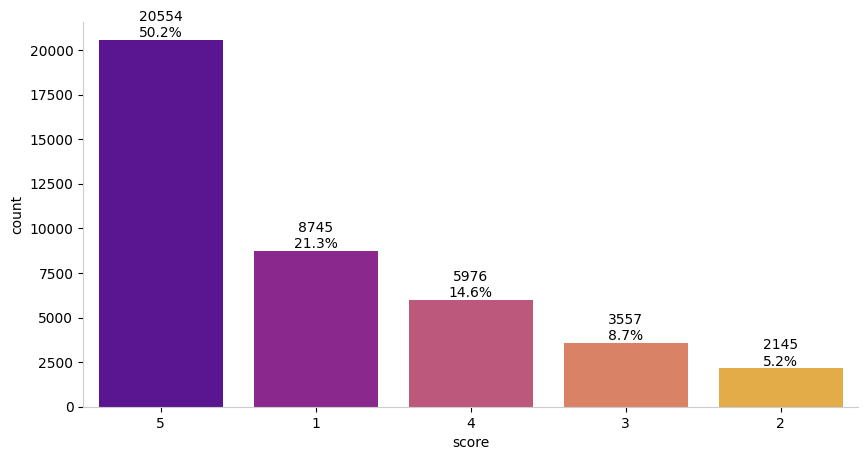

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
single_countplot(x='score', df=df_comments, ax=ax)

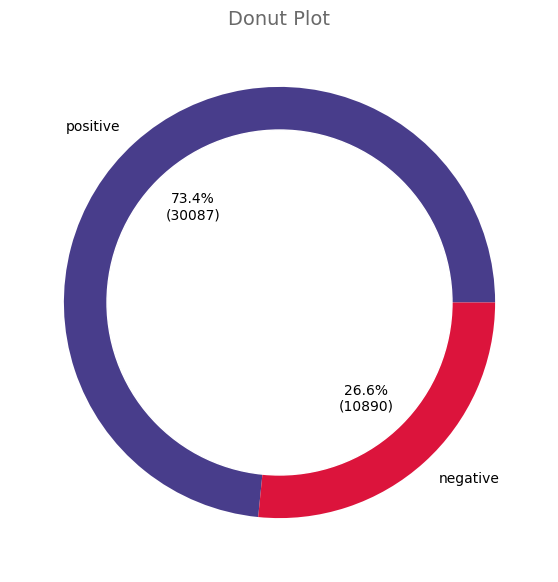

In [32]:
# Labelling data
score_map = {
    1: 'negative',
    2: 'negative',
    3: 'positive',
    4: 'positive',
    5: 'positive'
}
df_comments['sentiment_label'] = df_comments['score'].map(score_map)

# Verifying results
fig, ax = plt.subplots(figsize=(7, 7))
donut_plot(df_comments.query('sentiment_label in ("positive", "negative")'), 'sentiment_label', 
           label_names=df_comments.query('sentiment_label in ("positive", "negative")')['sentiment_label'].value_counts().index,
           ax=ax, colors=['darkslateblue', 'crimson'])

In [33]:
def ngrams_count(corpus, ngram_range, n=-1, cached_stopwords=stopwords.words('portuguese')):
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

In [34]:
# Splitting the corpus into positive and negative comments
positive_comments = df_comments.query('sentiment_label == "positive"')['stemming']
negative_comments = df_comments.query('sentiment_label == "negative"')['stemming']

# Extracting the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)

# Extracting the top 10 unigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)

# Extracting the top 10 unigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)

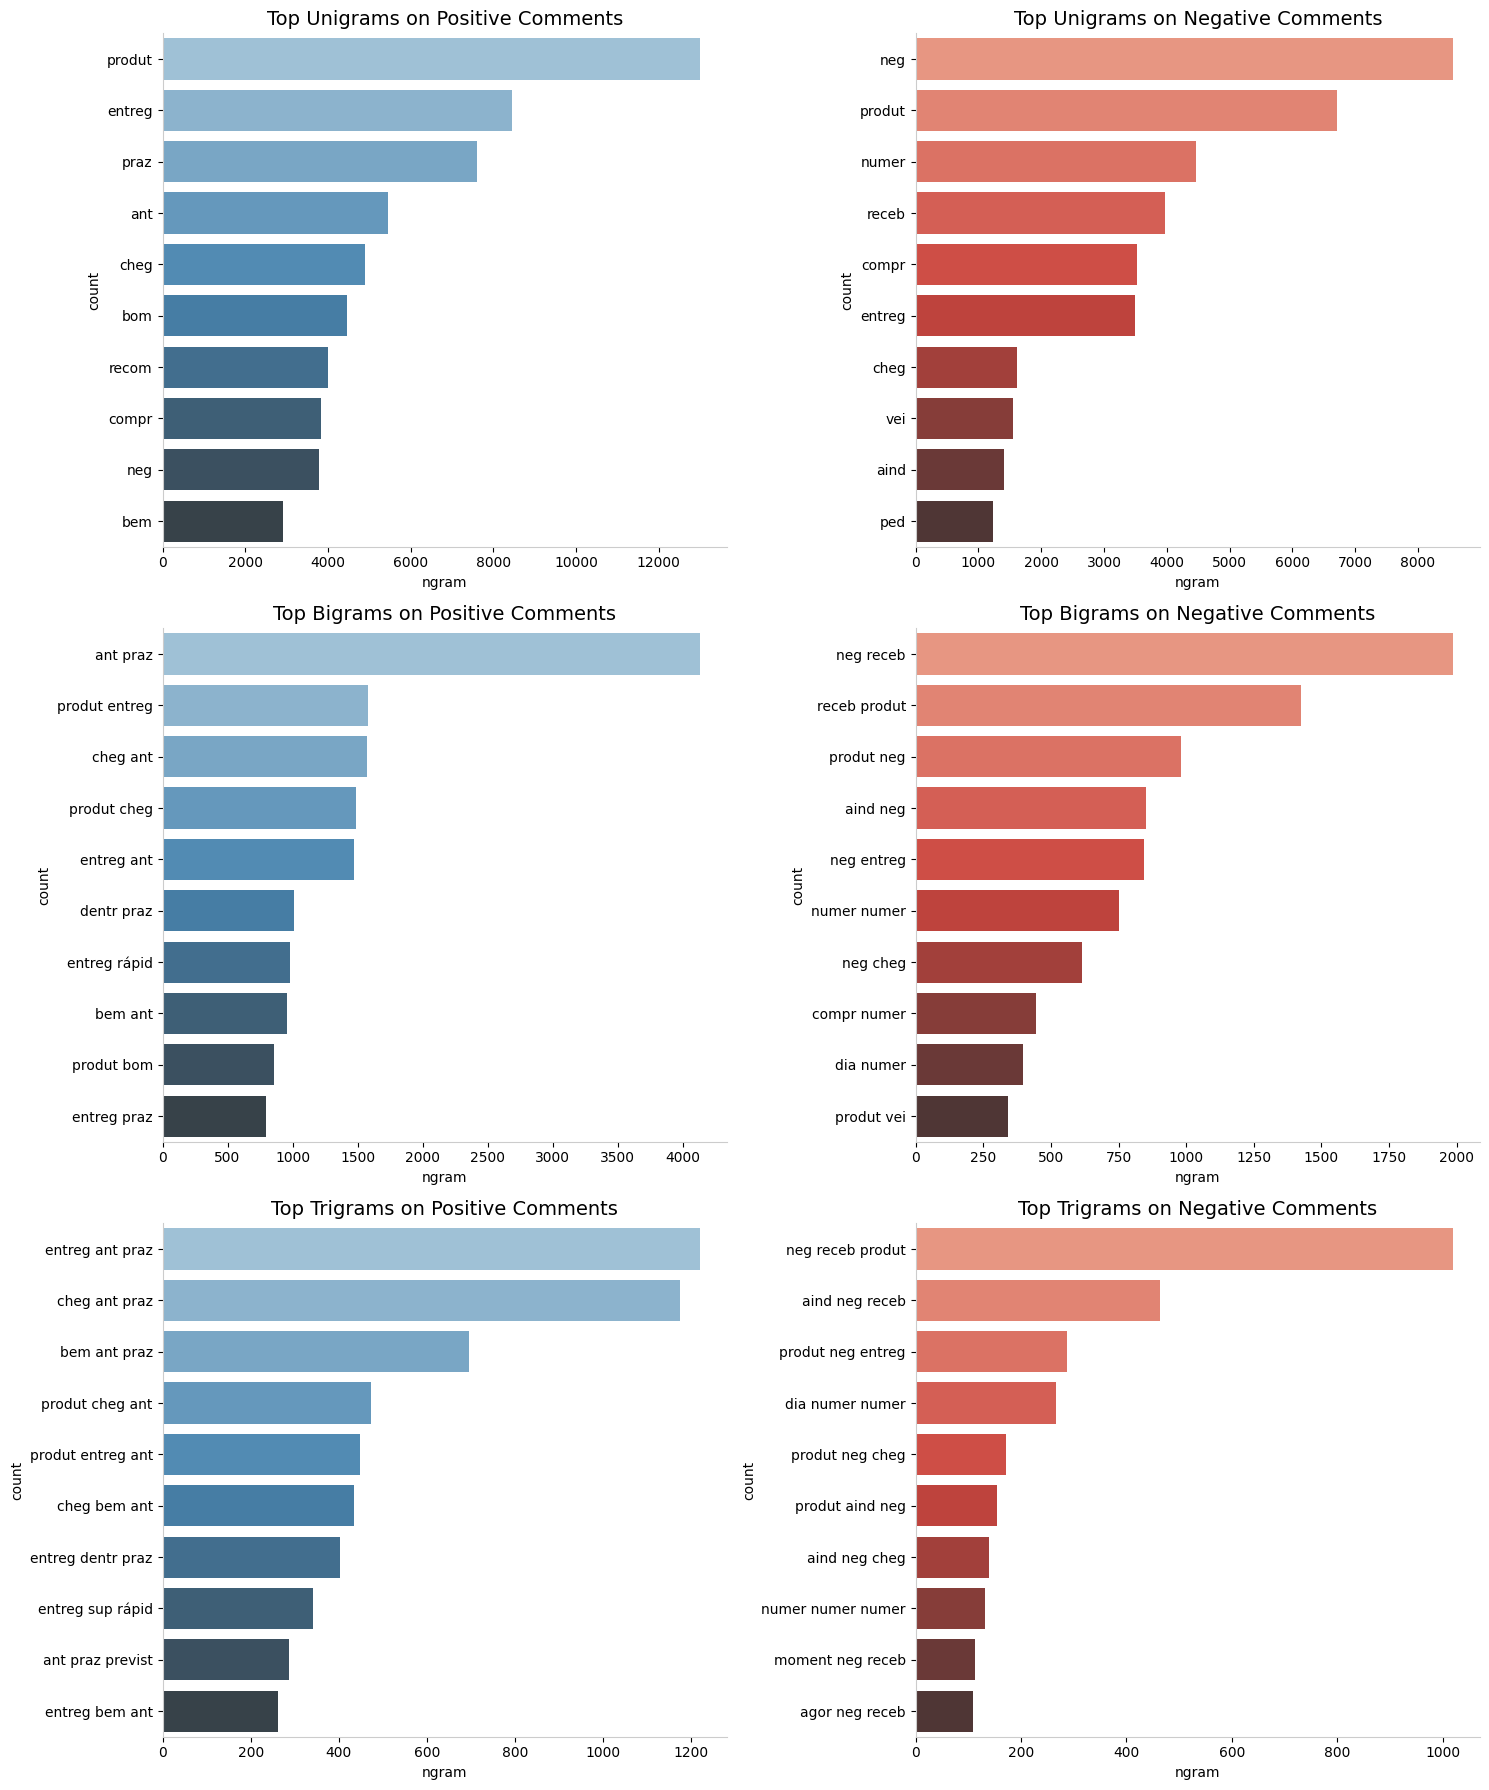

In [35]:
# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('count')
    ax.set_xlabel('ngram')
    
    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1
plt.tight_layout()
plt.show()

In [36]:
# Class for regular expressions application
class ApplyRegex(BaseEstimator, TransformerMixin):
    
    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Applying all regex functions in the regex_transformers dictionary
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)
            
        return X

# Class for stopwords removal from the corpus
class StopWordsRemoval(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stopwords_removal(comment, self.text_stopwords)) for comment in X]

# Class for apply the stemming process
class StemmingProcess(BaseEstimator, TransformerMixin):
    
    def __init__(self, stemmer):
        self.stemmer = stemmer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stemming_process(comment, self.stemmer)) for comment in X]
    
# Class for extracting features from corpus
class TextFeatureExtraction(BaseEstimator, TransformerMixin):
    
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return self.vectorizer.fit_transform(X).toarray()

In [37]:
# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hiperlinks': re_hiperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

# Building the Pipeline
text_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(RSLPStemmer())),
    ('text_features', TextFeatureExtraction(vectorizer))
])

In [38]:
# Defining X and y 
idx_reviews = olist_order_reviews['review_comment_message'].dropna().index
score = olist_order_reviews['review_score'][idx_reviews].map(score_map)

# Splitting into train and test sets
X = list(olist_order_reviews['review_comment_message'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

# Applying the pipeline and splitting the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.20, random_state=42)

# Verifying results
print(f'Length of X_train_processed: {len(X_train)} - Length of one element: {len(X_train[0])}')
print(f'Length of X_test_processed: {len(X_test)} - Length of one element: {len(X_test[0])}')

Length of X_train_processed: 32781 - Length of one element: 300
Length of X_test_processed: 8196 - Length of one element: 300


In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def classify_evaluate(model, X, Y):
    y_pred = model.predict(X)
    cm = confusion_matrix(Y,y_pred)
    plt.figure(figsize=(2,2))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', 
                xticklabels=np.unique(Y), 
                yticklabels=np.unique(Y))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    report = classification_report(Y, y_pred)
    print(report)
    return y_pred

In [40]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(fit_intercept=True)
model.fit(X_train, y_train)

LogisticRegression()

In [41]:
from joblib import dump, load
dump(model, 'models/logistic_sentiment.joblib')
model = load('models/logistic_sentiment.joblib') 

In [42]:
import skops.io as sio
sio.dump(model, 'models/logistic_sentiment.skops')
unknown_types = sio.get_untrusted_types(file="models/logistic_sentiment.skops")
model = sio.load("models/logistic_sentiment.skops", trusted=unknown_types)
#model = sio.loads("models/logistic_sentiment.skops", trusted=True)

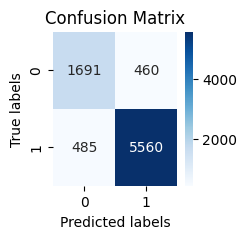

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      2151
           1       0.92      0.92      0.92      6045

    accuracy                           0.88      8196
   macro avg       0.85      0.85      0.85      8196
weighted avg       0.89      0.88      0.88      8196



In [43]:
ypred = classify_evaluate(model, X_test, y_test)

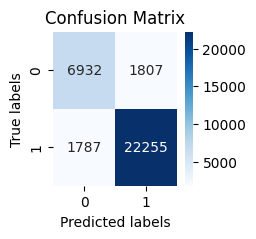

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      8739
           1       0.92      0.93      0.93     24042

    accuracy                           0.89     32781
   macro avg       0.86      0.86      0.86     32781
weighted avg       0.89      0.89      0.89     32781



In [44]:
ypred = classify_evaluate(model, X_train, y_train)

In [45]:
# Defining a function to plot the sentiment of a given phrase
def sentiment_analysis(text, pipeline, vectorizer, model):
    
    # Applying the pipeline
    if type(text) is not list:
        text = [text]
    text_prep = pipeline.transform(text)
    matrix = vectorizer.transform(text_prep)
    
    # Predicting sentiment
    pred = model.predict(matrix)
    proba = model.predict_proba(matrix)
    
    # Plotting the sentiment and its score
    fig, ax = plt.subplots(figsize=(5, 3))
    if pred[0] == 1:
        text = 'Positive'
        class_proba = 100 * round(proba[0][1], 2)
        color = 'seagreen'
    else:
        text = 'Negative'
        class_proba = 100 * round(proba[0][0], 2)
        color = 'crimson'
    ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
    ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha='center')
    ax.axis('off')
    ax.set_title('Sentiment Analysis', fontsize=14)
    plt.show()

In [46]:
prod_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(RSLPStemmer()))
])
vectorizer = text_pipeline.named_steps['text_features'].vectorizer

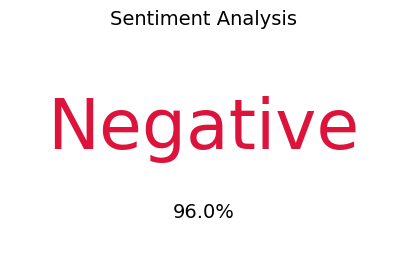

In [47]:
comment = 'Péssimo produto! Não compro nessa loja, a entrega atrasou e custou muito dinheiro!'
# Terrible product! I don't buy from this store, the delivery was late and cost a lot of money!
sentiment_analysis(comment, pipeline=prod_pipeline,vectorizer=vectorizer, model=model)

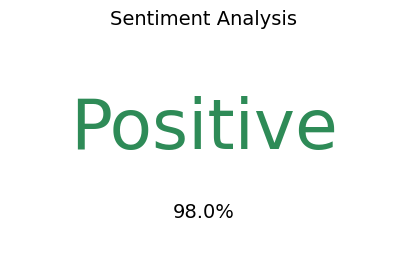

In [48]:
comment = 'Adorei e realmente cumpriu as expectativas. Comprei por um valor barato. Maravilhoso'
# I loved it and it really lived up to expectations. I bought it for a cheap price. Wonderful
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

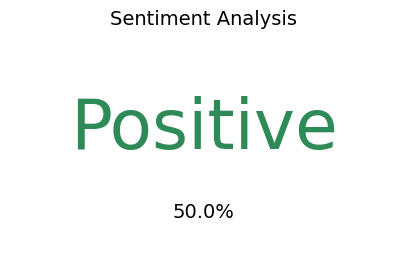

In [49]:
comment = 'Tenho sentimentos confusos sobre este produto. O design é elegante, mas o desempenho às vezes pode ser inconsistente. Foi fácil de configurar, mas as instruções careciam de clareza em algumas partes. O preço parece justo, mas não estou totalmente convencido de que seja o melhor valor comparado aos concorrentes. No geral, é um produto mediano que não me impressionou nem me deixou desapontado.'
# I have mixed feelings about this product. The design is sleek, but the performance can be inconsistent at times. It was easy to set up, yet the instructions lacked clarity in parts. The price seems fair, but I'm not fully convinced it's the best value compared to competitors. Overall, it's an average product that didn't quite wow me or leave me disappointed.
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

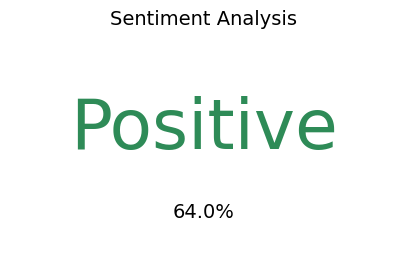

In [50]:
comment = 'Este produto me deixou desapontado. Apesar de suas afirmações promissoras, ficou aquém das minhas expectativas. O desempenho foi medíocre e não notei nenhuma melhoria significativa em seus supostos benefícios. Embora o preço fosse razoável, eu esperava mais retorno pelo meu investimento. No geral, foi uma experiência decepcionante.'
# This product left me feeling underwhelmed. Despite its promising claims, it fell short of my expectations. The performance was lackluster, and I didn't notice any significant improvement in its supposed benefits. While the price was reasonable, I expected more bang for my buck. Overall, it was a disappointing experience.
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

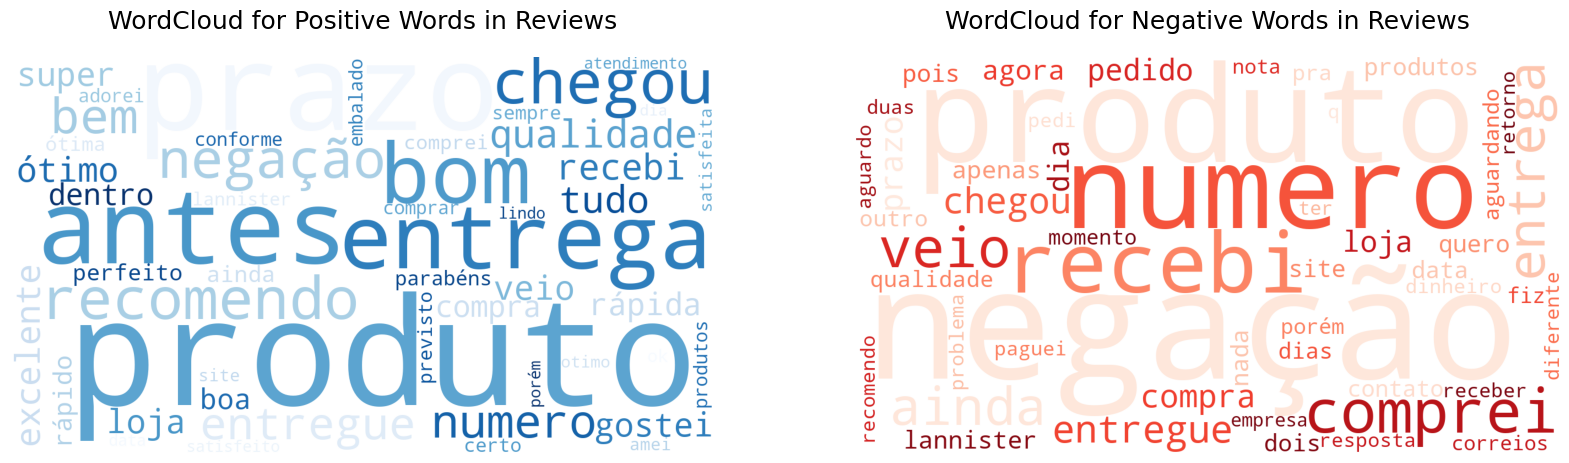

In [51]:
# Generating words
pos_comments = list(df_comments.query('sentiment_label == "positive"')['stopwords_removed'].values)
positive_words = ' '.join(pos_comments).split(' ')
neg_comments = list(df_comments.query('sentiment_label == "negative"')['stopwords_removed'].values)
negative_words = ' '.join(neg_comments).split(' ')

# Using Counter for creating a dictionary counting
positive_dict = Counter(positive_words)
negative_dict = Counter(negative_words)

# Generating wordclouds for both positive and negative comments
positive_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42,
                      colormap='Blues', background_color='white', max_words=50).generate_from_frequencies(positive_dict)
negative_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42,
                      colormap='Reds', background_color='white', max_words=50).generate_from_frequencies(negative_dict)

# Visualizing the WC created and the total for each cuisine
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
ax1 = axs[0]
ax2 = axs[1]

ax1.imshow(positive_wc)
ax1.axis('off')
ax1.set_title('WordCloud for Positive Words in Reviews', size=18, pad=20)

ax2.imshow(negative_wc)
ax2.axis('off')
ax2.set_title('WordCloud for Negative Words in Reviews', size=18, pad=20)

plt.show()